In [1]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import os
from scipy.fftpack import dct, idct
from collections import defaultdict
import matplotlib.pyplot as plt
import cv2
import math
import json
import re

/home/issa-sangare/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [14]:
path = 'img_gray.jpeg'
path1 = 'text1.txt'
path2 = 'reconstiued1.jpeg'
num_rows = 2
num_colors = 16
num_bloc = 16
image = Image.open(path)

# (-) $Caractéristiques$ $de$ $l'image$

In [3]:
def details(path):
    img = Image.open(path)
    size = img.size
    format = img.format
    mode = img.mode
    resolution = img.info.get('dpi')
    definition = size[0] * size[1]
    definition2 = size
    if resolution is not None:
        size = (size[0]/ resolution[0], size[1] / resolution[1])
    else:
        size = (0, 0)  # or any default resolution you want to use
    
    poids = os.path.getsize(path) / (1000.0)  # Convert to kilobytes
    
    if mode == 'RGB':
        trsc = definition * 3 * img.bits
    else:
        trsc = definition * 1 * img.bits
    
    trsc /= (1024 * 8)
    
    taux_compression = 100 * (1 - (poids/trsc))
        
    return size, format, mode, resolution, definition, definition2, poids, trsc, taux_compression


# Exemple d'utilisation
result = details(path)
print("Size (inch):", result[0])
print("Format:", result[1])
print("Mode:", result[2])
print("Resolution:", result[3])
print("Definition (pixels):", result[4])
print("Définition (L * C):", result[5])
print("Taille en mémoire avec compression:", result[6], "KB")
print("Taille réelle sans compression:", result[7]/1024, "MB")
print("Taux de compression: ", result[8], "%")

Size (inch): (0, 0)
Format: JPEG
Mode: L
Resolution: None
Definition (pixels): 892080
Définition (L * C): (1260, 708)
Taille en mémoire avec compression: 103.189 KB
Taille réelle sans compression: 0.8507537841796875 MB
Taux de compression:  88.15515021074343 %


# (1). $Création$ $de$ $la$ $palette$ $de$ $couleurs$

### (a). $Sens$ $normaux$

#### (i). $k-Means$ $Clustering$

In [4]:
def rgb_to_ycbcr(rgb_image):
    rgb_image = np.array(rgb_image)
    ycrcb_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2YCrCb)
    return ycrcb_image

In [5]:
def kmeans_clustering_palette(img, num_colors):
    # Convert the image into a 2D array of pixels
    image = Image.open(img)
    pixels = np.array(image)
    
    # Check if the image is grayscale or RGB
    if len(image.getbands()) == 1:  # Grayscale image
        pixels = pixels.reshape(-1, 1)
    elif len(image.getbands()) == 3:  # RGB image
        # Convert RGB image to YCbCr color space
        ycrcb_image = rgb_to_ycbcr(image)
        pixels = np.reshape(ycrcb_image, (-1, 3))  # (number of pixels, 3 color channels)
    
    # Apply the k-means clustering algorithm
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)

    # Get the cluster centers (dominant colors)
    color_palette = kmeans.cluster_centers_.astype(int)

    # Associate each pixel with the color index in the palette
    labels = kmeans.predict(pixels)

    # Reshape the color indices in the palette according to the shape of the original image
    palette_indices = np.reshape(labels, np.array(image).shape[:2])

    return color_palette, palette_indices


#### (ii). $Median$ $Cut$

In [6]:
def median_cut_palette(image, num_colors):
    # Convertir l'image en un tableau 2D de pixels
    pixels = np.reshape(image, (-1, 3))

    # Initialiser la liste des cubes de couleur avec le cube contenant tous les pixels
    cubes = [pixels]

    # Répéter jusqu'à ce que le nombre de cubes atteigne le nombre de couleurs souhaité
    while len(cubes) < num_colors:
        # Sélectionner le cube le plus grand
        largest_cube_index = np.argmax([cube.shape[0] for cube in cubes])
        largest_cube = cubes.pop(largest_cube_index)

        # Trouver l'axe dominant pour diviser le cube
        axis = np.argmax(np.max(largest_cube, axis=0) - np.min(largest_cube, axis=0))

        # Trier les pixels du cube le long de l'axe dominant
        sorted_cube = largest_cube[largest_cube[:, axis].argsort()]

        # Diviser le cube en deux parties égales
        split_index = len(sorted_cube) // 2
        cube1 = sorted_cube[:split_index]
        cube2 = sorted_cube[split_index:]

        # Ajouter les deux nouveaux cubes à la liste
        cubes.append(cube1)
        cubes.append(cube2)

    # Calculer les couleurs moyennes pour chaque cube
    color_palette = [np.mean(cube, axis=0) for cube in cubes]
    color_palette = np.array(color_palette).astype(np.uint8)

    # Calculer les indices des couleurs dans la palette pour chaque pixel de l'image
    palette_indices = np.zeros(len(pixels), dtype=int)
    for i, pixel in enumerate(pixels):
        distances = np.linalg.norm(color_palette - pixel, axis=1)
        palette_indices[i] = np.argmin(distances)

    palette_indices = np.reshape(palette_indices, np.array(image).shape[:2])

    return color_palette, palette_indices

#### (iii). $Octree$

In [7]:
def octree_palette(image, num_colors):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
        
    img_rgb = image.convert("RGB")
    img_with_palette = img_rgb.quantize(colors=num_colors, method=Image.FASTOCTREE)
    palette = img_with_palette.getpalette()[:num_colors * 3]
    palette = np.array(palette).reshape(-1, 3)
    indices = np.array(img_with_palette)

    # Retourner la palette de couleurs et leurs indices
    return palette, indices

### (b). $Sens$ $inverses$

#### (i). $k-Means$ $Clustering$

In [8]:
def inverse_kmeans_clustering_palette(color_palette, palette_indices):
    # Flatten the palette indices
    flat_indices = palette_indices.flatten()

    # Reconstruct the image using the color palette and palette indices
    reconstructed_image = color_palette[flat_indices]

    # Reshape the reconstructed image to its original shape
    original_shape = palette_indices.shape + (reconstructed_image.shape[-1],)
    reconstructed_image = reconstructed_image.reshape(original_shape)

    # Convert reconstructed image to uint8 data type
    reconstructed_image = np.uint8(reconstructed_image)

    return reconstructed_image

#### (ii). $Median$ $Cut$

In [9]:
def inverse_median_cut_palette(color_palette, palette_indices):
    # Récupérer les dimensions de l'image à partir des indices de palette
    height, width = palette_indices.shape

    # Initialiser une image vide avec les dimensions récupérées
    reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Remplir l'image reconstruite avec les couleurs de la palette
    for i in range(height):
        for j in range(width):
            color_index = palette_indices[i, j]
            reconstructed_image[i, j] = color_palette[color_index]
  
    return reconstructed_image

#### (iii). $Octree$

In [10]:
def inverse_octree_palette(color_palette, palette_indices):
    color_palette = color_palette.reshape(-1)
    color_palette = [(int(color_palette[i]), int(color_palette[i + 1]), int(color_palette[i + 2])) for i in range(0, len(color_palette), 3)]
    reconstructed_image = Image.new("RGB", (palette_indices.shape[1], palette_indices.shape[0]))
    reconstructed_image.putdata([color_palette[idx] for idx in palette_indices.flatten()])
  
    return reconstructed_image

### (c). $Application$

In [31]:
def display_image_with_palette(image, color_palette, palette_indices, num_rows):
    num_colors = len(color_palette)
    num_cols = num_colors // num_rows

    image_with_palette = color_palette[palette_indices]

    plt.figure(figsize=(30, 15))
    for i, color in enumerate(color_palette):
        plt.subplot(num_rows, num_cols, i + 1)
        color_patch = np.zeros((100, 100, 3), dtype=np.uint8)
        color_patch[:, :] = color
        plt.imshow(color_patch)
        plt.title(f'Couleur {i+1}')
        plt.axis('off')
    plt.suptitle('Palette de couleurs', fontsize=16)
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(30, 15))
    fig.subplots_adjust(wspace=0.01)

    axs[0].imshow(image)
    axs[0].set_title('Image originale')
    axs[0].axis('off')

    axs[1].imshow(image_with_palette)
    axs[1].set_title(f'Image avec la palette de {num_colors} couleurs')
    axs[1].axis('off')

    fig.tight_layout()

    plt.show()

In [20]:
def plot_images(reconstructed_image, image1, num_colors):
    fig, axs = plt.subplots(1, 2, figsize=(30, 15))
    fig.subplots_adjust(wspace=0.01)

    axs[0].imshow(reconstructed_image, cmap='gray')
    axs[0].set_title('Image reconstruite')
    axs[0].axis('off')

    axs[1].imshow(image1, cmap='gray')
    axs[1].set_title(f'Image avec la palette de {num_colors} couleurs (median-cut)')
    axs[1].axis('off')

    fig.tight_layout()

    plt.show()

In [13]:
def MSE(image_d_origine, image_traitee):
    # Get the dimensions of the images
    L, C = np.array(image_d_origine).shape[:2]  # Assuming it's a 2D image, getting rows and columns
    image_traitee = np.array(image_traitee).reshape(np.array(image_d_origine).shape)
    # Convert the images to NumPy arrays
    origine = np.array(image_d_origine)
    traitee = np.array(image_traitee)

    # Calculate the sum of squared differences
    somme_differences_carrees = np.sum((origine - traitee) ** 2)

    # Calculate (1 / (L * C)) * somme
    resultat = (1 / (L * C)) * somme_differences_carrees

    return resultat

/home/issa-sangare/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


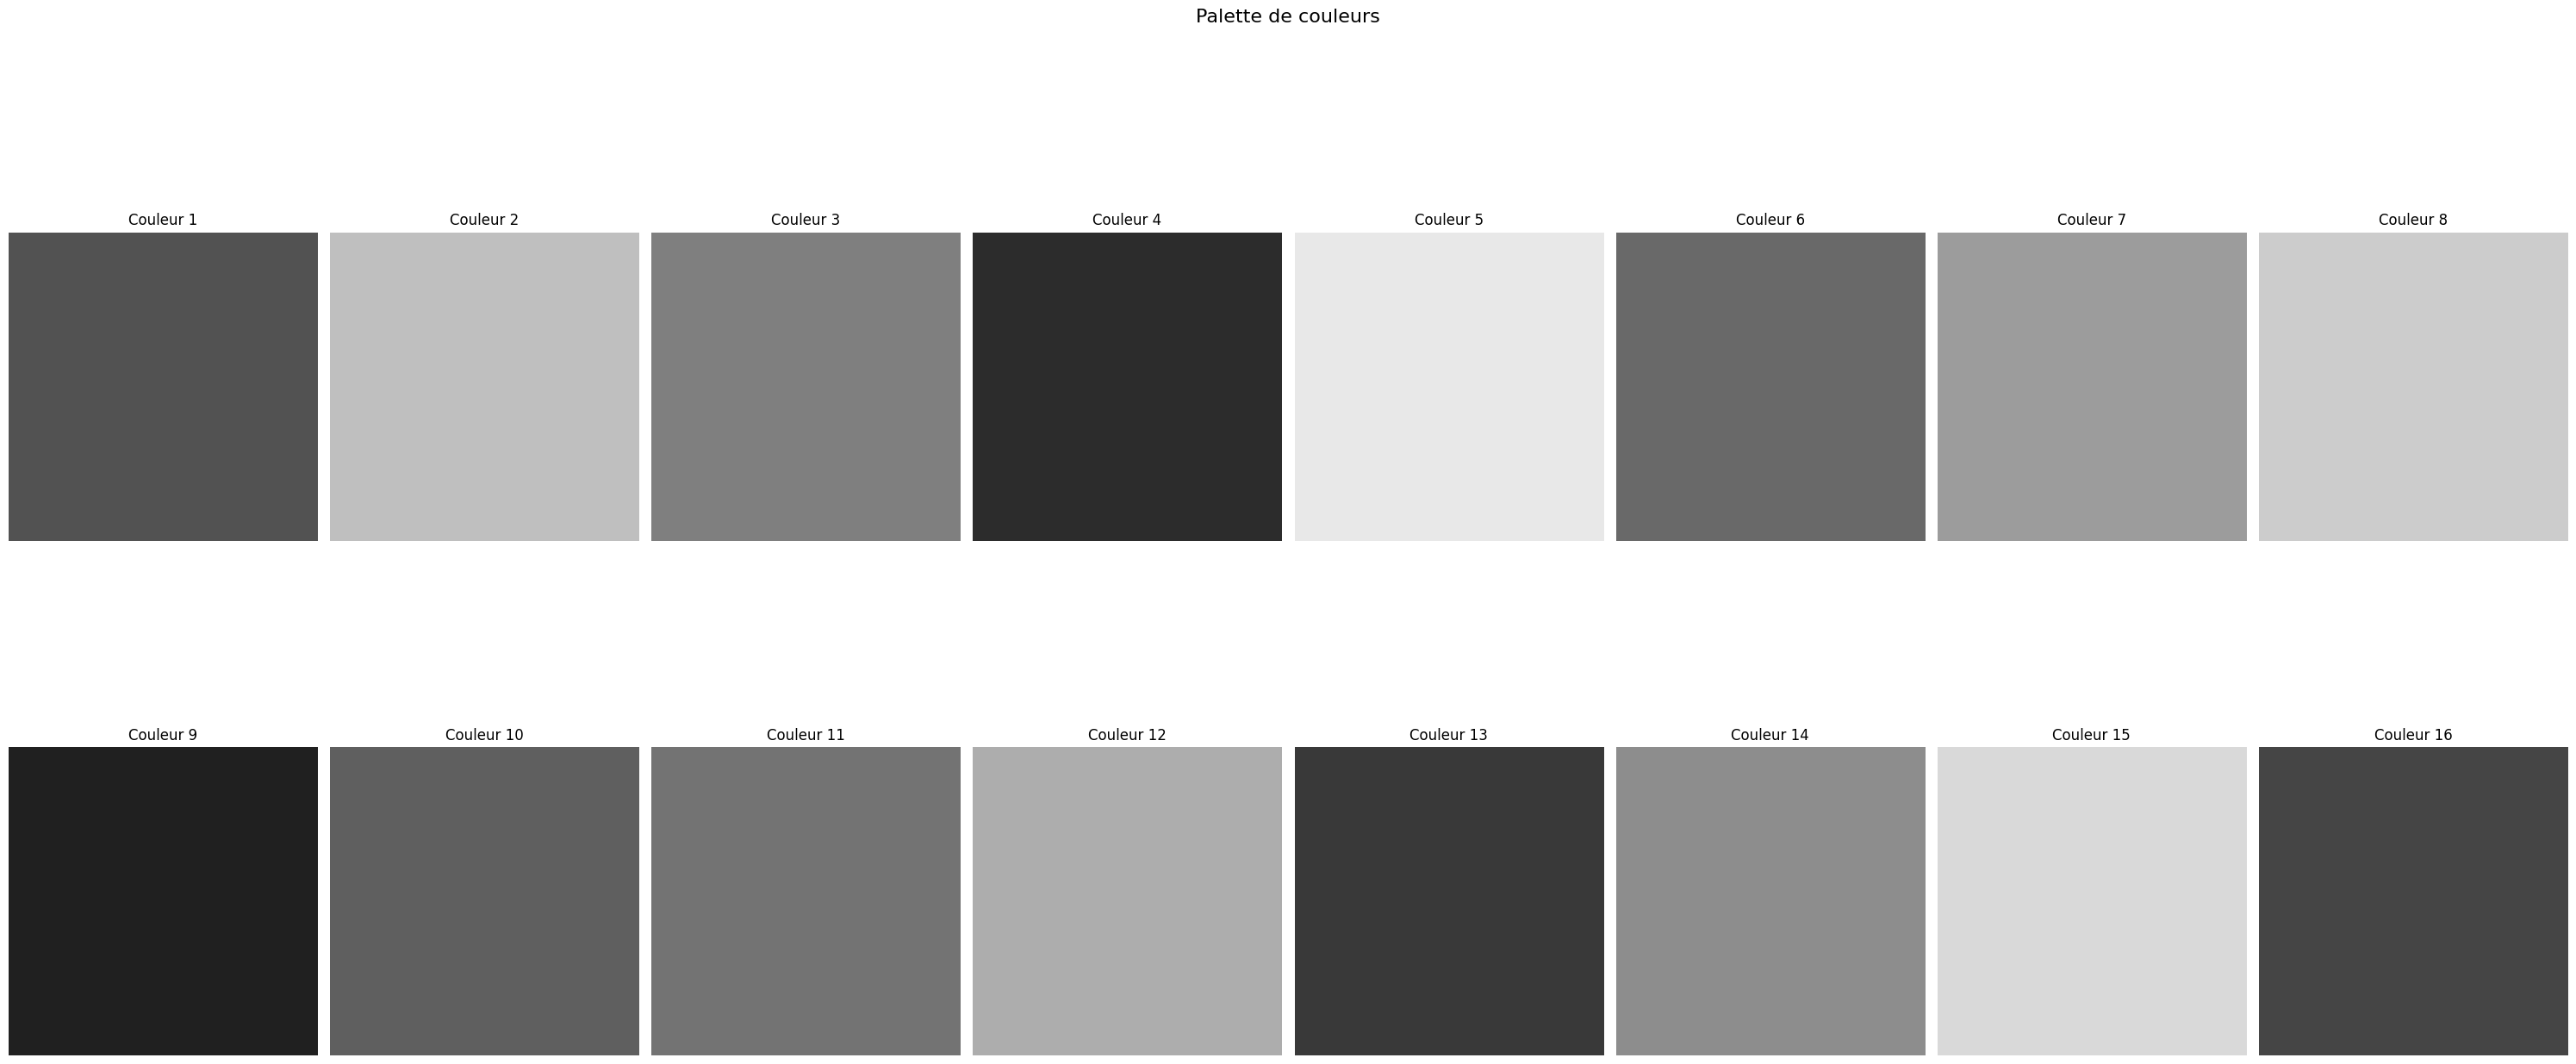

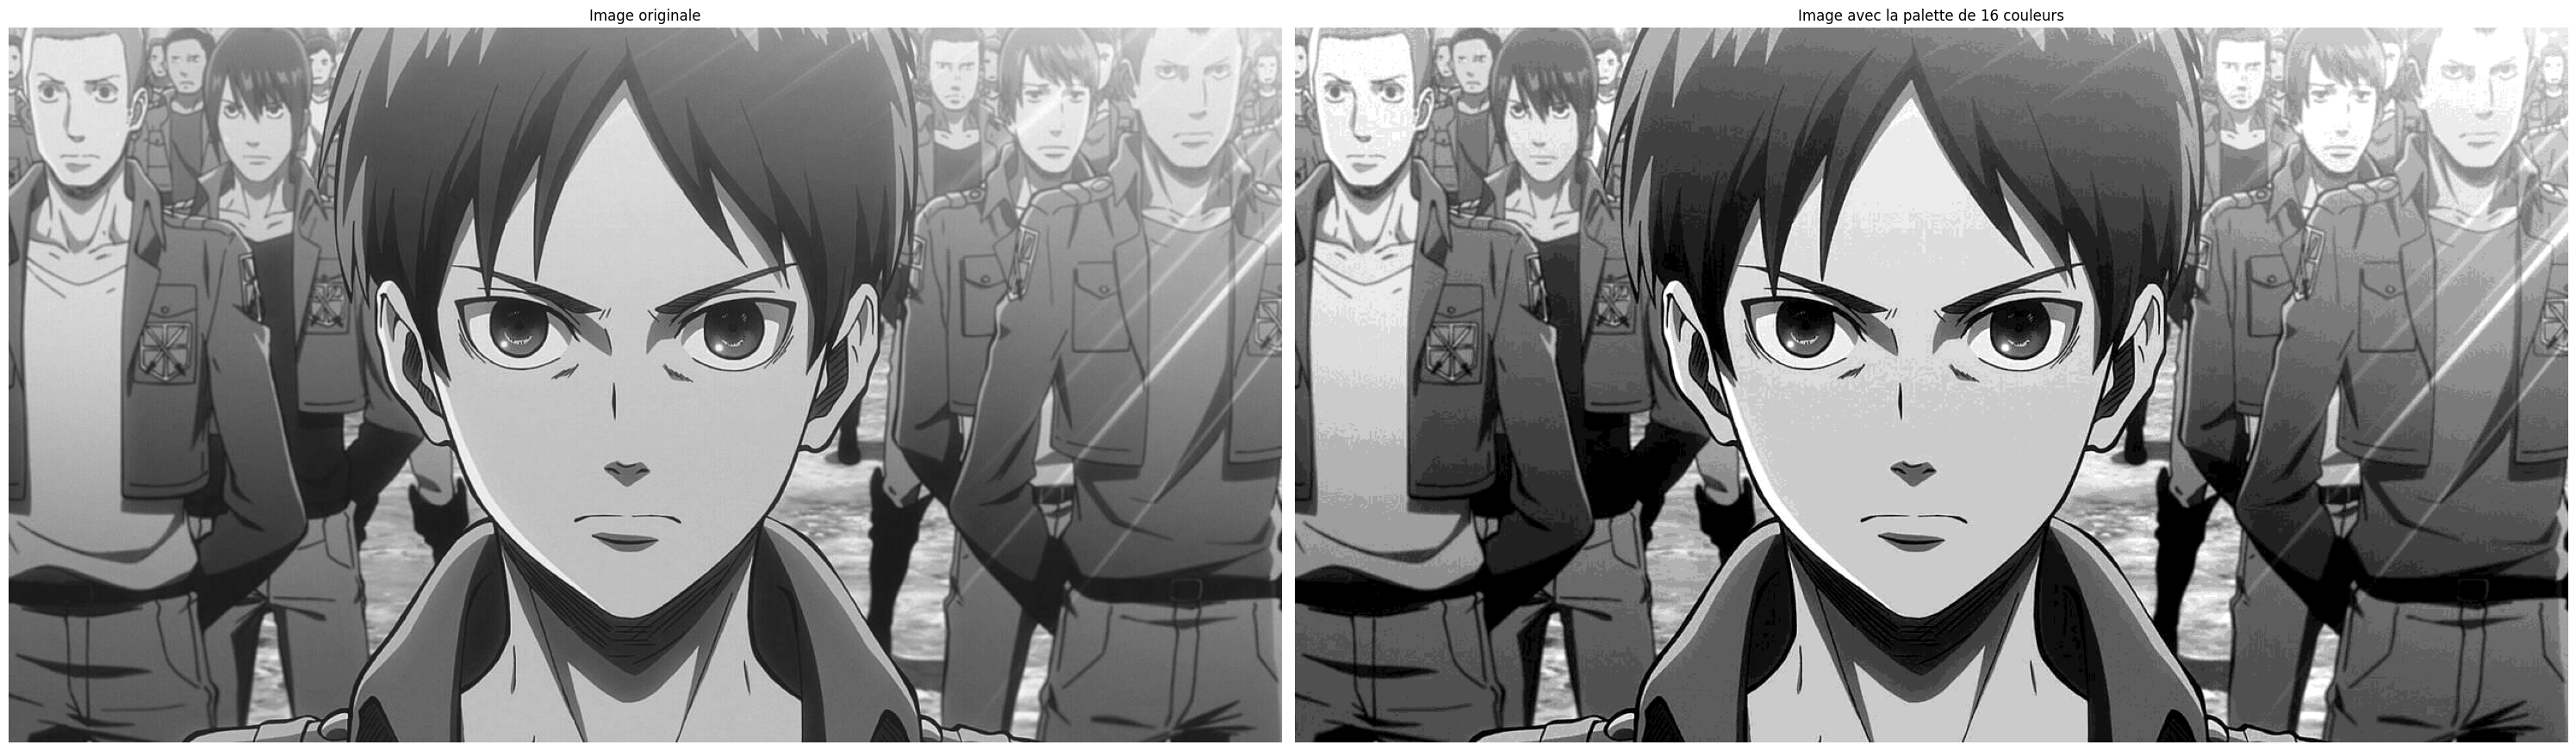

L'erreur quadratique moyenne (MSE) 1 est: 15.110333153977221


In [32]:
# Exemple d'utilisation
# Remplacez 'votre_image.jpg' par le chemin vers votre image
#image = plt.imread(path)
color_palette1, palette_indices1 = kmeans_clustering_palette(path, num_colors)
display_image_with_palette(image, color_palette1, palette_indices1, num_rows)
# Example usage with two matrices (reconstructed_image and image)
erreur11a = MSE(image, color_palette1[palette_indices1])
print(f"L'erreur quadratique moyenne (MSE) 1 est: {erreur11a}")

In [16]:
print(np.array(color_palette1[palette_indices1])[:,:,0][0:10])
print(np.array(color_palette1[palette_indices1])[:,:,1][0:10])
print(np.array(color_palette1[palette_indices1])[:,:,2][0:10])

[[ 45 152 187 ... 147 164  60]
 [ 45 152 187 ... 147 164  60]
 [ 45 152 187 ... 147 164  60]
 ...
 [ 45 152 187 ... 147 164  60]
 [ 45 152 187 ... 147 164  60]
 [ 45 152 187 ... 147 164  60]]
[[ 30 202 210 ... 134 149  42]
 [ 30 202 210 ... 134 149  42]
 [ 30 202 210 ... 134 149  42]
 ...
 [ 30 202 210 ... 134 149  42]
 [ 30 202 210 ... 134 149  42]
 [ 30 202 210 ... 134 149  42]]
[[ 27 214 215 ... 127 140  40]
 [ 27 214 215 ... 127 140  40]
 [ 27 214 215 ... 127 140  40]
 ...
 [ 27 214 215 ... 127 140  40]
 [ 27 214 215 ... 127 140  40]
 [ 27 214 215 ... 127 140  40]]


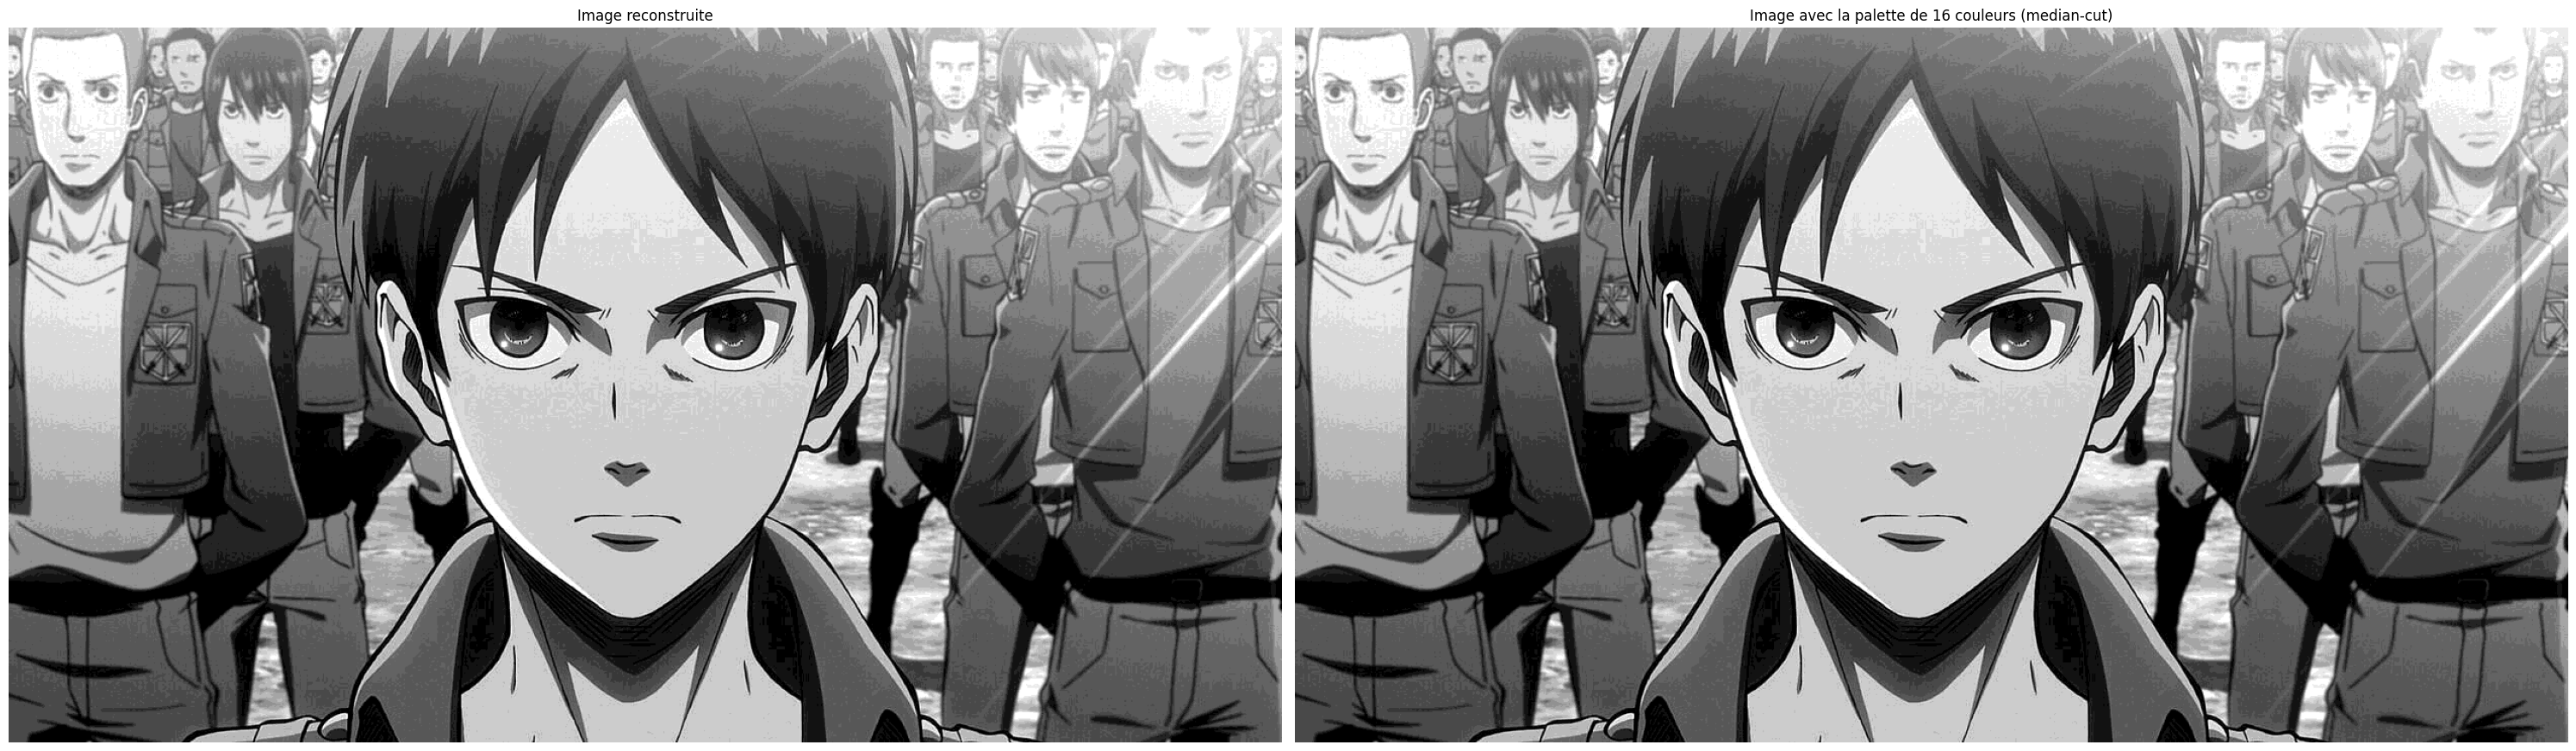

L'erreur quadratique moyenne (MSE) k-means clustering est: 0.0


In [22]:
reconstructed_image1 = inverse_kmeans_clustering_palette(color_palette1, palette_indices1)
image11 = color_palette1[palette_indices1]

plot_images(reconstructed_image1, image11, num_colors)

erreur11b = MSE(reconstructed_image1, image11)
print(f"L'erreur quadratique moyenne (MSE) k-means clustering est: {erreur11b}")

In [18]:
print()
'''
# Exemple d'utilisation
# Remplacez 'votre_image.jpg' par le chemin vers votre image
image = plt.imread(path)
color_palette2, palette_indices2 = median_cut_palette(image, num_colors)
display_image_with_palette(image, color_palette2, palette_indices2, num_rows)
# Example usage with two matrices (reconstructed_image and image)
erreur12a = MSE(image, color_palette2[palette_indices2])
print(f"L'erreur quadratique moyenne (MSE) 2 est: {erreur12a}")
'''
print()

In [19]:
print()
'''
print(np.array(color_palette2[palette_indices2])[:,:,0][0:10])
print(np.array(color_palette2[palette_indices2])[:,:,1][0:10])
print(np.array(color_palette2[palette_indices2])[:,:,2][0:10])
'''
print()

In [20]:
print()
'''
reconstructed_image2 = inverse_median_cut_palette(color_palette2, palette_indices2)
image12 = color_palette2[palette_indices2]

plot_images(reconstructed_image2, image12, num_colors)

erreur12b = MSE(reconstructed_image2, image12)
print(f"L'erreur quadratique moyenne (MSE) median-cut est: {erreur12b}")
'''
print()

In [21]:
print()
'''
# Exemple d'utilisation
# Remplacez 'votre_image.jpg' par le chemin vers votre image
image = plt.imread(path)
color_palette3, palette_indices3 = octree_palette(image, num_colors)
display_image_with_palette(image, color_palette3, palette_indices3, num_rows)
# Example usage with two matrices (reconstructed_image and image)
erreur13a = MSE(image, color_palette3[palette_indices3])
print(f"L'erreur quadratique moyenne (MSE) 3 est: {erreur13a}")
'''
print()

In [22]:
print()
'''
print(np.array(color_palette3[palette_indices3])[:,:,0][0:10])
print(np.array(color_palette3[palette_indices3])[:,:,1][0:10])
print(np.array(color_palette3[palette_indices3])[:,:,2][0:10])
'''
print()

In [23]:
print()
'''
reconstructed_image3 = inverse_octree_palette(color_palette3, palette_indices3)
image13 = color_palette3[palette_indices3]

plot_images(reconstructed_image3, image13, num_colors)

erreur13b = MSE(reconstructed_image3, image13)
print(f"L'erreur quadratique moyenne (MSE) octree est: {erreur13b}")
'''
print()

# (2). $Mappage$ $des$ $pixels$ $de$ $l'image$

### (a). $Sens$ $normal$

In [50]:
def map_to_palette(image, color_palette):
    # Assurez-vous que l'image est sous forme de tableau numpy
    image = image.convert('YCbCr')
    image = np.array(image)
    
    # Redimensionner les pixels en une matrice (nombre de pixels, 3 canaux de couleur)
    pixels = np.reshape(image, (-1, 3))  

    # Calculer la distance de chaque pixel à chaque couleur de la palette
    distances = np.linalg.norm(pixels[:, np.newaxis] - color_palette, axis=2)

    # Obtenir l'indice de la couleur la plus proche pour chaque pixel
    indices = np.argmin(distances, axis=1)

    # Reformater les indices des couleurs selon la forme de l'image originale
    mapped_indices = np.reshape(indices, image.shape[:2])

    return np.array(mapped_indices)

### (b). $Sens$ $inverse$

In [51]:
def inverse_map_to_palette(mapped_indices, color_palette):
    # Obtenir les dimensions de l'image reconstruite
    height, width = mapped_indices.shape

    # Créer une image vide
    reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Pour chaque pixel, assigner la couleur correspondante de la palette
    for i in range(height):
        for j in range(width):
            color_index = mapped_indices[i, j]
            reconstructed_image[i, j] = color_palette[color_index]

    return Image.fromarray(reconstructed_image)

### (c). $Application$

In [52]:
data = map_to_palette(image, color_palette1)

In [53]:
data

array([[13, 13,  6, ...,  6,  6,  6],
       [13,  6,  6, ...,  6,  6,  6],
       [13,  6,  6, ...,  6,  6,  6],
       ...,
       [10, 10, 10, ...,  2,  2,  2],
       [10, 10, 10, ...,  2,  2,  2],
       [10, 10, 10, ...,  2,  2,  2]])

In [54]:
data.shape

(708, 1260)

(708, 1260, 1)


(708, 1260, 3)


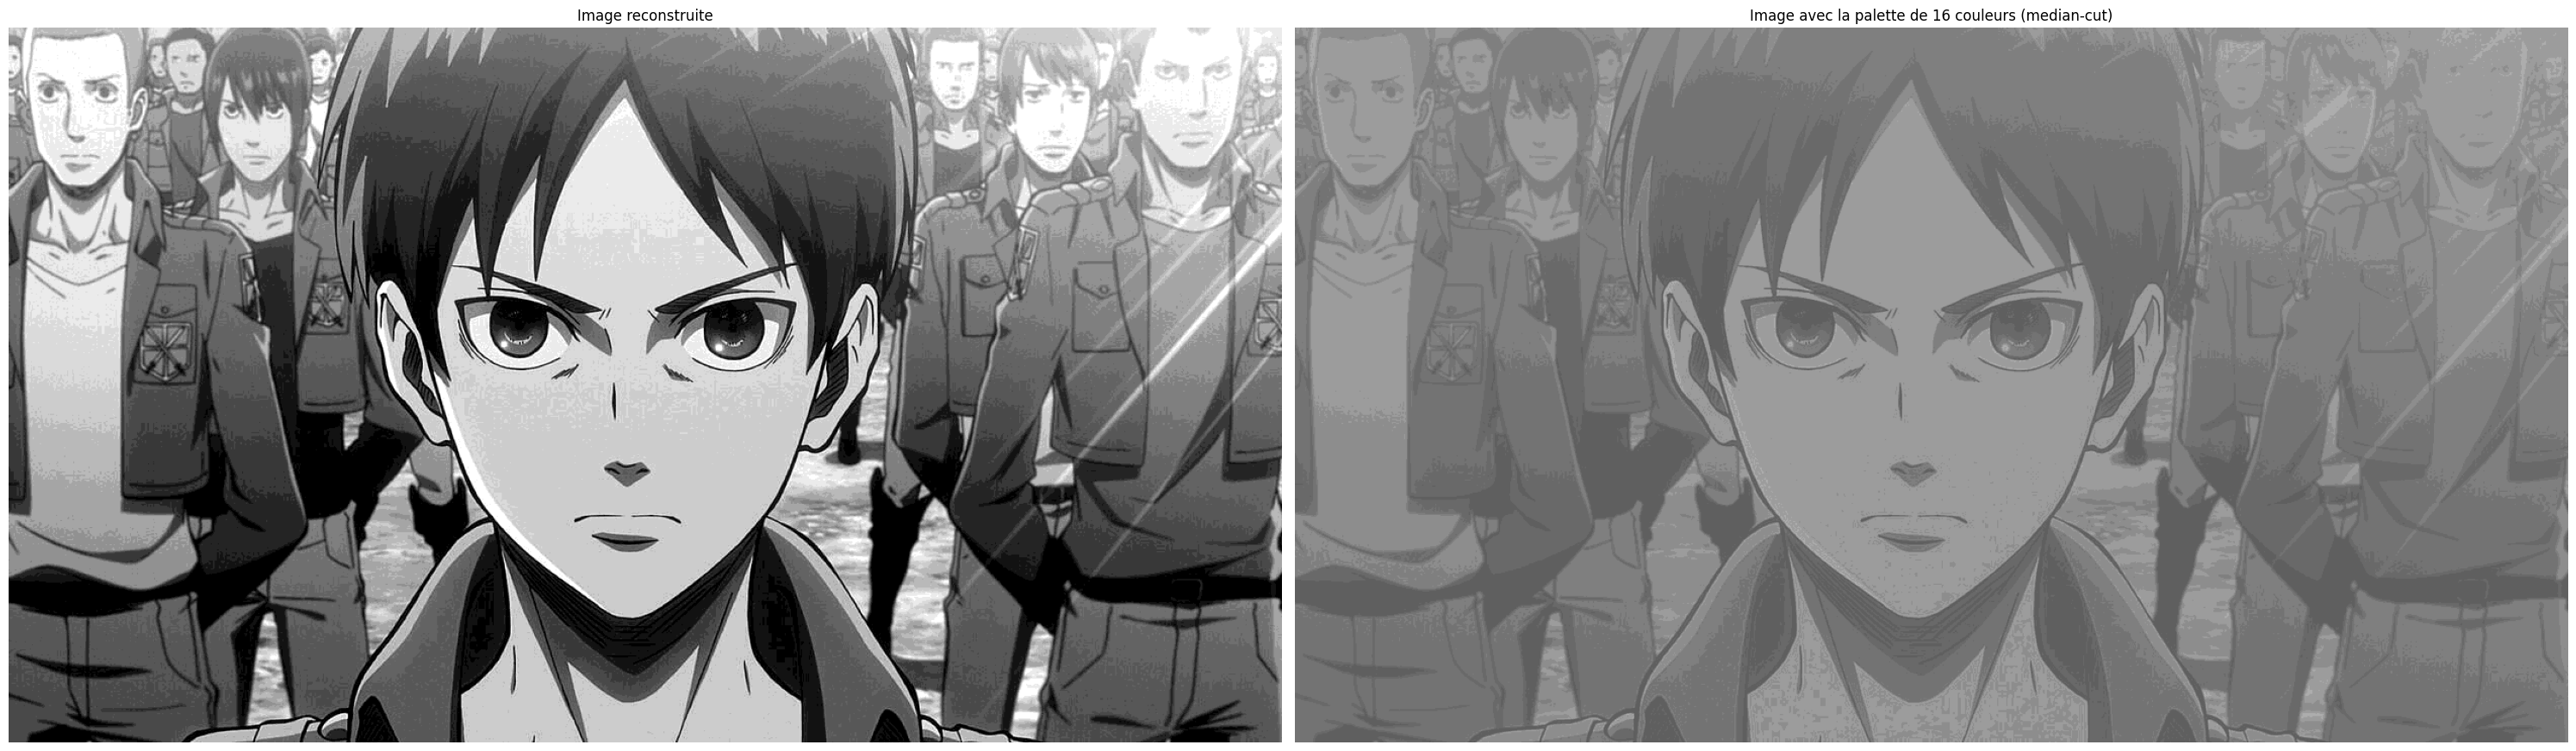

ValueError: cannot reshape array of size 2676240 into shape (708,1260)

In [59]:
print(np.array(image11).shape)

atad = inverse_map_to_palette(data, color_palette1)
print(np.array(atad).shape)

plot_images(image11, atad, num_colors)

erreur = MSE(np.array(image), np.array(atad))
print(f"L'erreur quadratique moyenne (MSE) est: {erreur}")

# (3). $Subdivision$ $en$ $blocs$ $de$ $pixels$

### (a). $Sens$ $normal$

In [30]:
def subdivision3D(image, taille_bloc):

    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    # Obtenir la largeur et la hauteur de l'image
    largeur, hauteur = image.size

    # Calculer le nombre de blocs en largeur et en hauteur
    blocs_largeur = (largeur + taille_bloc - 1) // taille_bloc
    blocs_hauteur = (hauteur + taille_bloc - 1) // taille_bloc

    # Créer une nouvelle image avec les dimensions ajustées
    nouvelle_largeur = blocs_largeur * taille_bloc
    nouvelle_hauteur = blocs_hauteur * taille_bloc
    nouvelle_image = Image.new(image.mode, (nouvelle_largeur, nouvelle_hauteur), color='black')
    nouvelle_image.paste(image, (0, 0))

    blocs = []
    # Parcourir chaque bloc
    for y in range(blocs_hauteur):
        for x in range(blocs_largeur):
            # Obtenir les coordonnées du coin supérieur gauche du bloc
            coin_sup_gauche_x = x * taille_bloc
            coin_sup_gauche_y = y * taille_bloc
            # Obtenir les coordonnées du coin inférieur droit du bloc
            coin_inf_droit_x = (x + 1) * taille_bloc
            coin_inf_droit_y = (y + 1) * taille_bloc
            # Extraire le bloc de l'image
            bloc = nouvelle_image.crop((coin_sup_gauche_x, coin_sup_gauche_y, coin_inf_droit_x, coin_inf_droit_y))
            blocs.append(bloc)
            # Afficher le bloc
            plt.subplot(blocs_hauteur, blocs_largeur, y * blocs_largeur + x + 1)
            plt.imshow(bloc)
            plt.axis('off')

    # Afficher les blocs
    plt.figure(figsize=(20, 10))
    plt.show()
    
    return blocs, (largeur, hauteur)

In [31]:
def subdivision2D(matrice, taille_blocs):
    # Dimensions de la matrice initiale
    lignes, colonnes = matrice.shape
    
    # Dimensions des blocs
    blocs_lignes, blocs_colonnes = (taille_blocs, taille_blocs)
    
    # Calcul des dimensions des blocs avec zéros ajoutés
    new_blocs_lignes = (lignes + blocs_lignes - 1) // blocs_lignes
    new_blocs_colonnes = (colonnes + blocs_colonnes - 1) // blocs_colonnes
    
    # Initialisation de la matrice des sous-matrices
    sous_matrices = np.zeros((new_blocs_lignes, new_blocs_colonnes, blocs_lignes, blocs_colonnes))
    
    # Remplissage de la matrice des sous-matrices
    for i in range(new_blocs_lignes):
        for j in range(new_blocs_colonnes):
            sous_matrices[i, j, :min(blocs_lignes, lignes - i*blocs_lignes), :min(blocs_colonnes, colonnes - j*blocs_colonnes)] = \
                matrice[i*blocs_lignes:(i+1)*blocs_lignes, j*blocs_colonnes:(j+1)*blocs_colonnes]
    
    return sous_matrices, (lignes, colonnes)

### (b). $Sens$ $inverse$

In [32]:
def reconstition3D(blocs, taille_bloc, dimensions_originales):
    largeur_orig, hauteur_orig = dimensions_originales
    
    # Créer une nouvelle image vide avec les dimensions originales
    image_reconstituee = np.zeros((hauteur_orig, largeur_orig, 3), dtype=np.uint8)
    
    # Parcourir chaque bloc et le placer à la position correspondante dans l'image reconstituée
    idx = 0
    for y in range(0, hauteur_orig, taille_bloc):
        for x in range(0, largeur_orig, taille_bloc):
            # Extraire le bloc de l'image reconstituée
            bloc = blocs[idx]
            idx += 1
            # Convertir le bloc en tableau numpy
            bloc_np = np.array(bloc, dtype=np.uint8)
            
            if bloc_np.shape[2] > bloc_np.shape[0]:
                bloc_np = np.transpose(bloc_np, (2, 1, 0))
            # Calculer les coordonnées de collage du bloc dans l'image reconstituée
            x_end = min(x + taille_bloc, largeur_orig)
            y_end = min(y + taille_bloc, hauteur_orig)
            # Coller le bloc dans l'image reconstituée
            image_reconstituee[y:y_end, x:x_end] = bloc_np[:y_end-y, :x_end-x]

    # Créer une image PIL à partir du tableau numpy
    image_reconstituee_pil = Image.fromarray(image_reconstituee)
    
    return image_reconstituee_pil

In [33]:
def reconstition2D(sous_matrices, dimensions_originales):
    lignes, colonnes = dimensions_originales
    new_blocs_lignes, new_blocs_colonnes, blocs_lignes, blocs_colonnes = sous_matrices.shape
    
    matrice_combinee = np.zeros((lignes, colonnes))
    
    for i in range(new_blocs_lignes):
        for j in range(new_blocs_colonnes):
            matrice_combinee[i*blocs_lignes:(i+1)*blocs_lignes, j*blocs_colonnes:(j+1)*blocs_colonnes] = \
                sous_matrices[i, j, :min(blocs_lignes, lignes - i*blocs_lignes), :min(blocs_colonnes, colonnes - j*blocs_colonnes)]
    
    return matrice_combinee

In [34]:
matrice_aleatoire = np.random.randint(0, 100, size=(10, 10))

In [35]:
matrice_aleatoire

array([[30, 62, 49, 22, 10, 15, 78, 51, 88, 35],
       [53, 54, 30, 50,  1, 68, 20, 96, 50, 57],
       [31, 61,  2, 86, 17, 99, 59, 43, 28, 49],
       [23, 53, 44, 33, 80, 13, 52, 41, 74, 57],
       [37, 92, 89, 69, 73, 91, 63,  4, 28, 53],
       [52,  1, 95,  7, 44,  3, 68, 43,  7, 25],
       [83, 99, 60, 12, 87,  3, 70, 87,  7,  4],
       [24, 21, 24, 36, 51, 99, 30, 81, 55, 92],
       [31, 27, 78, 79,  4,  2, 41, 70, 52, 77],
       [ 8, 42, 55, 65, 88, 79, 72, 66, 88, 49]])

In [36]:
bloc, size  = subdivision2D(matrice_aleatoire, 4)

In [37]:
bloc[0]

array([[[30., 62., 49., 22.],
        [53., 54., 30., 50.],
        [31., 61.,  2., 86.],
        [23., 53., 44., 33.]],

       [[10., 15., 78., 51.],
        [ 1., 68., 20., 96.],
        [17., 99., 59., 43.],
        [80., 13., 52., 41.]],

       [[88., 35.,  0.,  0.],
        [50., 57.,  0.,  0.],
        [28., 49.,  0.,  0.],
        [74., 57.,  0.,  0.]]])

In [38]:
bloc

array([[[[30., 62., 49., 22.],
         [53., 54., 30., 50.],
         [31., 61.,  2., 86.],
         [23., 53., 44., 33.]],

        [[10., 15., 78., 51.],
         [ 1., 68., 20., 96.],
         [17., 99., 59., 43.],
         [80., 13., 52., 41.]],

        [[88., 35.,  0.,  0.],
         [50., 57.,  0.,  0.],
         [28., 49.,  0.,  0.],
         [74., 57.,  0.,  0.]]],


       [[[37., 92., 89., 69.],
         [52.,  1., 95.,  7.],
         [83., 99., 60., 12.],
         [24., 21., 24., 36.]],

        [[73., 91., 63.,  4.],
         [44.,  3., 68., 43.],
         [87.,  3., 70., 87.],
         [51., 99., 30., 81.]],

        [[28., 53.,  0.,  0.],
         [ 7., 25.,  0.,  0.],
         [ 7.,  4.,  0.,  0.],
         [55., 92.,  0.,  0.]]],


       [[[31., 27., 78., 79.],
         [ 8., 42., 55., 65.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 4.,  2., 41., 70.],
         [88., 79., 72., 66.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  

In [39]:
(matrice_aleatoire == reconstition2D(bloc, size)).all()

True

### (c). $Application$

In [40]:
blocs, shape = subdivision2D(data, num_bloc)

In [41]:
blocs[0][0]

array([[ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30.,  7.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
         7.,  7.,  7.],
       [ 5.,  7., 22., 30., 30.,  7., 30., 30.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.],
       [ 5.,  7., 22., 30.,  7.,  7.,  7., 30.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.],
       [ 5.,  7., 22.,  7.,  7

In [42]:
blocs[0][0].shape

(16, 16)

In [43]:
# Votre code pour créer et afficher l'image
image_reconstituee = reconstition2D(blocs, shape)
print(len(np.array(blocs)))
print(len(np.array(image_reconstituee)))

'''
a3 = reconstituer_image(a1, bloc, a2)
plt.figure(figsize=(30, 15))  # Remplacez largeur et hauteur par les dimensions souhaitées en pouces

plt.imshow(a3)
plt.xticks([])  # Supprimer les marques de l'axe des x
plt.yticks([])  # Supprimer les marques de l'axe des y
plt.show()
'''

# Calculer et afficher l'erreur
erreur = MSE(data, image_reconstituee)
print(f"L'erreur quadratique moyenne (MSE) est: {erreur}")

45
708
L'erreur quadratique moyenne (MSE) est: 0.0


## $(Dans$ $tout$ $ce$ $qui$ $suit,$ $le$ $traitement$ $est$ $fait$ $sur$ $chaque$ $bloc$ $de$ $pixels$ $de$ $l'image$ $et$ $non$ $sur$ $l'image$ $entière$ $directement)$

# (4). $Sous$ $échantillonnage$

### (a). $Sens$ $normaux$

#### (i). $4:2:0$

In [44]:
def sous_echantillonnage_4_2_0(image):
    # Sous-échantillonnage de l'image
    sub_image = image[::2, ::2]
    
    return sub_image

#### (ii). $4:2:2$

In [45]:
def sous_echantillonnage_4_2_2(image):
    # Sous-échantillonnage de l'image
    sub_image = image[::1, ::2]
    
    return sub_image

#### (iii). $4:4:4$

In [46]:
def sous_echantillonnage_4_4_4(image):
    # La fonction ne fait rien car il n'y a pas de sous-échantillonnage pour le 4:4:4
    return image.copy() 

### (a). $Sens$ $inverses$

#### (i). $4:2:0$

In [47]:
def inverse_sous_echantillonnage_4_2_0(imSub):
    # Répétition des pixels pour restaurer la résolution horizontale
    H, W = imSub.shape
    res_h = np.repeat(imSub, 2, axis=1)
    
    # Répétition des pixels pour restaurer la résolution verticale
    res_v = np.repeat(res_h, 2, axis=0)
    
    return res_v

#### (ii). $4:2:2$

In [48]:
def inverse_sous_echantillonnage_4_2_2(imSub):
    # Répétition des colonnes pour restaurer les canaux de chrominance
    res_h = np.repeat(imSub, 2, axis=1)
    
    return res_h

#### (iii). $4:4:4$

In [49]:
def inverse_sous_echantillonnage_4_4_4(imSub):
    # L'inverse du sous-échantillonnage 4:4:4 est simplement une copie de l'image d'entrée
    return imSub.copy()

### (c). $Application$

In [50]:
def creer_listes_carrees(liste):
    n = len(liste)
    taille = int(math.sqrt(n))
    
    list1 = []
    for i in range(0, n, taille):
        list2 = []
        for j in range(taille):
            list2.append(np.array(liste[i + j]))
        list1.append(np.array(list2))
    
    return np.array(list1)

In [51]:
def inverser_listes_carrees(matrice):
    liste_matrices = []
    for sous_matrice in matrice:
        for ligne in sous_matrice:
            liste_matrices.append(ligne)
    return liste_matrices

In [52]:
blocs[0][0]

array([[ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30.,  7.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
         7.,  7.,  7.],
       [ 5.,  7., 22., 30., 30.,  7., 30., 30.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.],
       [ 5.,  7., 22., 30.,  7.,  7.,  7., 30.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.],
       [ 5.,  7., 22.,  7.,  7

In [53]:
blocs = inverser_listes_carrees(blocs)

In [54]:
blocs

[array([[ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
         30., 30., 30.],
        [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
         30., 30., 30.],
        [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
         30., 30., 30.],
        [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
         30., 30., 30.],
        [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
         30., 30., 30.],
        [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
         30., 30., 30.],
        [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
         30., 30.,  7.],
        [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
          7.,  7.,  7.],
        [ 5.,  7., 22., 30., 30.,  7., 30., 30.,  7.,  7.,  7.,  7.,  7.,
          7.,  7.,  7.],
        [ 5.,  7., 22., 30.,  7.,  7.,  7., 30.,  7.,  7.,  7.,  7.,  7.,
          7.,  7.,  7.],
        [ 

In [55]:
blocs[0]

array([[ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30.,  7.],
       [ 5.,  7., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
         7.,  7.,  7.],
       [ 5.,  7., 22., 30., 30.,  7., 30., 30.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.],
       [ 5.,  7., 22., 30.,  7.,  7.,  7., 30.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.],
       [ 5.,  7., 22.,  7.,  7

In [56]:
# Exemple d'utilisation de la fonction
result1 = sous_echantillonnage_4_2_0(blocs[0])

const1 = inverse_sous_echantillonnage_4_2_0(result1)

In [57]:
result1

array([[ 5., 22., 30., 30., 30., 30., 30., 30.],
       [ 5., 22., 30., 30., 30., 30., 30., 30.],
       [ 5., 22., 30., 30., 30., 30., 30., 30.],
       [ 5., 22., 30., 30., 30., 30., 30., 30.],
       [ 5., 22., 30., 30.,  7.,  7.,  7.,  7.],
       [ 5., 22.,  7.,  7.,  7.,  7.,  7.,  7.],
       [ 5., 15.,  7.,  7.,  7.,  7.,  7.,  7.],
       [ 5., 15.,  7.,  7., 22., 22.,  7., 22.]])

In [58]:
result1.shape

(8, 8)

In [59]:
const1

array([[ 5.,  5., 22., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  5., 22., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  5., 22., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  5., 22., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  5., 22., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  5., 22., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  5., 22., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  5., 22., 22., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30.],
       [ 5.,  5., 22., 22., 30., 30., 30., 30.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.],
       [ 5.,  5., 22., 22., 30., 30., 30., 30.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.],
       [ 5.,  5., 22., 22.,  7

In [60]:
print()
'''
# Exemple d'utilisation de la fonction
result2 = sous_echantillonnage_4_2_2(blocs[0][0])
print("\n", result2)

const2 = inverse_sous_echantillonnage_4_2_2(result2)

print("\n", np.array(const2))
'''
print()

In [61]:
print()
'''
# Exemple d'utilisation de la fonction
result3 = sous_echantillonnage_4_4_4(blocs[0][0])
print("\n", result3)

const3 = inverse_sous_echantillonnage_4_4_4(result3)

print("\n", np.array(const3))
'''
print()

# (5). $Application$ $de$ $la$ $DCT$ $(Discret$ $Cosinus$ $Transform)$

### (a). $Sens$ $normal$

In [62]:
def apply_dct(matrix):
    # Appliquer la DCT à chaque matrice
    dct_matrix = dct(dct(matrix.T, norm='ortho').T, norm='ortho')
    
    return np.array(dct_matrix)

### (b). $Sens$ $inverse$

In [63]:
def inverse_dct(dct_matrix):
    # Appliquer l'inverse de la DCT à chaque matrice
    inverse_dct_matrix = idct(idct(dct_matrix.T, norm='ortho').T, norm='ortho')
    
    return np.array(inverse_dct_matrix)

### (c). $Application$

In [64]:
dct_matrix = apply_dct(result1)
print("\n", dct_matrix)

resul1 = inverse_dct(dct_matrix)
print("\n", resul1)
print("\n", result1)


 [[ 1.47625000e+02 -1.82063610e+01 -2.30185569e+01 -2.07346461e+01
  -1.33750000e+01 -1.30556047e+01 -4.94239725e+00 -5.82808338e+00]
 [ 5.53768243e+01 -1.85437171e+01 -1.51676991e+01 -1.08659846e+01
  -4.84325073e+00  7.82321006e+00  1.04036988e+00  3.88620067e+00]
 [-1.78010955e+00 -1.18875601e+01  4.74003878e+00  1.10497750e+01
   4.06659474e+00 -8.69221713e+00  2.43826208e+00  1.90492533e+00]
 [-2.32641606e+01  1.81008229e+01  4.20682348e+00 -4.02986322e+00
  -2.99224595e+00  4.91977990e+00 -4.98130702e+00 -2.81842002e+00]
 [ 1.13750000e+01 -1.53910537e+00 -6.32705000e+00 -4.37750156e+00
   1.87500000e+00 -2.14030653e-02  4.65023530e+00 -7.28475579e-01]
 [ 2.96292350e+00 -6.86660882e+00  2.24137994e+00  3.82143033e+00
  -9.47001271e-01  5.88367899e-01 -1.95343676e+00  2.46909493e+00]
 [ 6.02046494e-01 -3.34903024e+00  2.68826208e+00  4.20742923e+00
   3.45046681e-01 -5.45822431e+00 -7.40038777e-01 -2.63307646e-01]
 [-6.45908296e+00  1.02878511e+01 -3.49986686e+00 -7.19148208e+00
 

# (6). $Quantification$

### (a). $Sens$ $normal$

In [65]:
def quantization(matrix):
  # Déterminer la valeur minimale et maximale dans la matrice
    min_value = np.min(matrix)
    max_value = np.max(matrix)
    
    # Calculer la moyenne des valeurs
    mean_value = round((max_value + min_value) / 2)
    
    # Quantification en utilisant la valeur moyenne comme facteur de quantification
    quantized_dct = np.round(matrix / mean_value)
    
    return quantized_dct, mean_value

### (b). $Sens$ $inverse$

In [66]:
def dequantization(quantized_matrix, mean_value):
    return quantized_matrix * mean_value

### (c). $Appliction$

In [67]:
result11, mean_value = quantization(dct_matrix)
reconstructed_dct = dequantization(result11, mean_value)

print("Matrice DCT :\n\n", dct_matrix)
print("\nMatrice DCT quantifiée :\n\n", result11)
print("\nMatrice DCT reconstruite :\n\n", reconstructed_dct)

mse = MSE(dct_matrix, reconstructed_dct)
print("\n\nMSE entre la matrice DCT originale et la matrice DCT reconstruite:", mse)

Matrice DCT :

 [[ 1.47625000e+02 -1.82063610e+01 -2.30185569e+01 -2.07346461e+01
  -1.33750000e+01 -1.30556047e+01 -4.94239725e+00 -5.82808338e+00]
 [ 5.53768243e+01 -1.85437171e+01 -1.51676991e+01 -1.08659846e+01
  -4.84325073e+00  7.82321006e+00  1.04036988e+00  3.88620067e+00]
 [-1.78010955e+00 -1.18875601e+01  4.74003878e+00  1.10497750e+01
   4.06659474e+00 -8.69221713e+00  2.43826208e+00  1.90492533e+00]
 [-2.32641606e+01  1.81008229e+01  4.20682348e+00 -4.02986322e+00
  -2.99224595e+00  4.91977990e+00 -4.98130702e+00 -2.81842002e+00]
 [ 1.13750000e+01 -1.53910537e+00 -6.32705000e+00 -4.37750156e+00
   1.87500000e+00 -2.14030653e-02  4.65023530e+00 -7.28475579e-01]
 [ 2.96292350e+00 -6.86660882e+00  2.24137994e+00  3.82143033e+00
  -9.47001271e-01  5.88367899e-01 -1.95343676e+00  2.46909493e+00]
 [ 6.02046494e-01 -3.34903024e+00  2.68826208e+00  4.20742923e+00
   3.45046681e-01 -5.45822431e+00 -7.40038777e-01 -2.63307646e-01]
 [-6.45908296e+00  1.02878511e+01 -3.49986686e+00 -7.

# (7). $Vectorisation$

### (a). $Sens$ $normaux$

#### (i). $Par$ $ligne$

In [68]:
def ligne_scan(matrice):
  shape = matrice.shape
  vecteur = matrice.flatten()
  return np.array(vecteur), shape

#### (ii). $Par$ $colonne$

In [69]:
def colonne_scan(matrice):
    shape = matrice.shape
    vecteur = np.ravel(matrice, order = 'F')
    return np.array(vecteur), shape

#### (iii). $Par$ $zigzag$

In [70]:
def zigzag_scan(matrice):
  shape = matrice.shape
  vecteur = np.concatenate([np.diagonal(matrice[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1 - matrice.shape[0], matrice.shape[0])])
  return np.array(vecteur), shape

### (b). $Sens$ $inverses$

#### (i). $Par$ $ligne$

In [71]:
def inverse_ligne_scan(vecteur, shape):
  mat = np.array(vecteur).reshape((shape[0], shape[1]))
  return mat

#### (ii). $Par$ $colonne$

In [72]:
def inverse_colonne_scan(vecteur, shape):
    mat = np.array(vecteur).reshape((shape[0], shape[1]))
    return mat.T

#### (iii). $Par$ $zigzag$

In [73]:
def inverse_zigzag_scan(vector, shape):
    rows, cols = shape
    mat = np.array([[None] * cols for _ in range(rows)])
    row, col = 0, 0
    direction = 1

    for i in range(rows * cols):
        mat[row][col] = vector[i]
        if direction == 1:
            if col == cols - 1:
                row += 1
                direction = -1
            elif row == 0:
                col += 1
                direction = -1
            else:
                row -= 1
                col += 1
        else:
            if row == rows - 1:
                col += 1
                direction = 1
            elif col == 0:
                row += 1
                direction = 1
            else:
                row += 1
                col -= 1

    #return np.array(mat, dtype=np.uint8)
    return mat

### (c). $Application$

In [74]:
ligne, shape = ligne_scan(result11)
print(ligne, "\n")

inverse1 = inverse_ligne_scan(ligne, shape)
print(inverse1, "\n")
print(result11, "\n")

# Vérifier si toutes les comparaisons sont vraies (c'est-à-dire si toutes les matrices dans les deux listes sont égales)
if (result11 == inverse1).all():
    print("Les deux matrices sont identiques.")
else:
    print("Les deux matrices sont différentes.")

[ 2. -0. -0. -0. -0. -0. -0. -0.  1. -0. -0. -0. -0.  0.  0.  0. -0. -0.
  0.  0.  0. -0.  0.  0. -0.  0.  0. -0. -0.  0. -0. -0.  0. -0. -0. -0.
  0. -0.  0. -0.  0. -0.  0.  0. -0.  0. -0.  0.  0. -0.  0.  0.  0. -0.
 -0. -0. -0.  0. -0. -0. -0.  0.  0. -0.] 

[[ 2. -0. -0. -0. -0. -0. -0. -0.]
 [ 1. -0. -0. -0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0. -0.  0.  0.]
 [-0.  0.  0. -0. -0.  0. -0. -0.]
 [ 0. -0. -0. -0.  0. -0.  0. -0.]
 [ 0. -0.  0.  0. -0.  0. -0.  0.]
 [ 0. -0.  0.  0.  0. -0. -0. -0.]
 [-0.  0. -0. -0. -0.  0.  0. -0.]] 

[[ 2. -0. -0. -0. -0. -0. -0. -0.]
 [ 1. -0. -0. -0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0. -0.  0.  0.]
 [-0.  0.  0. -0. -0.  0. -0. -0.]
 [ 0. -0. -0. -0.  0. -0.  0. -0.]
 [ 0. -0.  0.  0. -0.  0. -0.  0.]
 [ 0. -0.  0.  0.  0. -0. -0. -0.]
 [-0.  0. -0. -0. -0.  0.  0. -0.]] 

Les deux matrices sont identiques.


In [75]:
colonne, shape = colonne_scan(result11)
print(colonne, "\n")

inverse2 = inverse_colonne_scan(colonne, shape)
print(inverse2, "\n")
print(result11, "\n")

# Vérifier si toutes les comparaisons sont vraies (c'est-à-dire si toutes les matrices dans les deux listes sont égales)
if (result11 == inverse2).all():
    print("Les deux matrices sont identiques.")
else:
    print("Les deux matrices sont différentes.")

[ 2.  1. -0. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0. -0.
  0.  0. -0.  0.  0. -0. -0. -0.  0. -0. -0.  0.  0. -0. -0. -0.  0. -0.
  0. -0.  0. -0. -0.  0. -0.  0. -0.  0. -0.  0. -0.  0.  0. -0.  0. -0.
 -0.  0. -0.  0.  0. -0. -0.  0. -0. -0.] 

[[ 2. -0. -0. -0. -0. -0. -0. -0.]
 [ 1. -0. -0. -0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0. -0.  0.  0.]
 [-0.  0.  0. -0. -0.  0. -0. -0.]
 [ 0. -0. -0. -0.  0. -0.  0. -0.]
 [ 0. -0.  0.  0. -0.  0. -0.  0.]
 [ 0. -0.  0.  0.  0. -0. -0. -0.]
 [-0.  0. -0. -0. -0.  0.  0. -0.]] 

[[ 2. -0. -0. -0. -0. -0. -0. -0.]
 [ 1. -0. -0. -0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0. -0.  0.  0.]
 [-0.  0.  0. -0. -0.  0. -0. -0.]
 [ 0. -0. -0. -0.  0. -0.  0. -0.]
 [ 0. -0.  0.  0. -0.  0. -0.  0.]
 [ 0. -0.  0.  0.  0. -0. -0. -0.]
 [-0.  0. -0. -0. -0.  0.  0. -0.]] 

Les deux matrices sont identiques.


In [76]:
zigzag, shape = colonne_scan(result11)
print(zigzag, "\n")

inverse3 = inverse_colonne_scan(zigzag, shape)
print(inverse3, "\n")
print(result11, "\n")

# Vérifier si toutes les comparaisons sont vraies (c'est-à-dire si toutes les matrices dans les deux listes sont égales)
if (result11 == inverse3).all():
    print("Les deux matrices sont identiques.")
else:
    print("Les deux matrices sont différentes.")

[ 2.  1. -0. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0. -0.
  0.  0. -0.  0.  0. -0. -0. -0.  0. -0. -0.  0.  0. -0. -0. -0.  0. -0.
  0. -0.  0. -0. -0.  0. -0.  0. -0.  0. -0.  0. -0.  0.  0. -0.  0. -0.
 -0.  0. -0.  0.  0. -0. -0.  0. -0. -0.] 

[[ 2. -0. -0. -0. -0. -0. -0. -0.]
 [ 1. -0. -0. -0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0. -0.  0.  0.]
 [-0.  0.  0. -0. -0.  0. -0. -0.]
 [ 0. -0. -0. -0.  0. -0.  0. -0.]
 [ 0. -0.  0.  0. -0.  0. -0.  0.]
 [ 0. -0.  0.  0.  0. -0. -0. -0.]
 [-0.  0. -0. -0. -0.  0.  0. -0.]] 

[[ 2. -0. -0. -0. -0. -0. -0. -0.]
 [ 1. -0. -0. -0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0. -0.  0.  0.]
 [-0.  0.  0. -0. -0.  0. -0. -0.]
 [ 0. -0. -0. -0.  0. -0.  0. -0.]
 [ 0. -0.  0.  0. -0.  0. -0.  0.]
 [ 0. -0.  0.  0.  0. -0. -0. -0.]
 [-0.  0. -0. -0. -0.  0.  0. -0.]] 

Les deux matrices sont identiques.


# (8). $Codage$ $par$ $Huffman$

### (-). $Fonctions$ $intermediaires$ $propres$ $à$ $Huffman$

In [77]:
def ext_chr(chaine):
    occ = {c: chaine.count(c) for c in set(chaine)}
    return sorted(occ.items(), key=lambda x: x[1], reverse=True)

# Fonction principale implémentant le codage de Huffman
def huffman_dictionnary_code(node, binString=''):
    if isinstance(node, str):
        return {node: binString}
    (l, r) = node
    d = {}
    d.update(huffman_dictionnary_code(l, binString + '0'))
    d.update(huffman_dictionnary_code(r, binString + '1'))
    return d

# Construction de l'arbre de Huffman
def huffman_tree(chaine):
    nodes = ext_chr(chaine)
    
    while len(nodes) > 1:
        (key1, c1) = nodes.pop()
        (key2, c2) = nodes.pop()
        node = (key1, key2)
        nodes.append((node, c1 + c2))
        nodes.sort(key=lambda x: x[1], reverse=True)
        
    return nodes[0][0]


### (a). $Sens$ $normal$

In [78]:
def encoding_huffman(strings):
    huffman_tree_result = huffman_tree(strings)  # Stockez l'arbre de Huffman dans une variable distincte
    huffmanCode = huffman_dictionnary_code(huffman_tree_result)
    compressed_string = ''
    
    for char in strings:
        compressed_string += huffmanCode[char]
        
    return compressed_string, huffman_tree_result


### (b). $Sens$ $inverse$

In [79]:
def decoding_huffman(compressed_string, huffman_tree):
    decoded_string = ''
    current_node = huffman_tree
    
    for bit in compressed_string:
        if bit == '0':
            current_node = current_node[0]
        else:
            current_node = current_node[1]
        
        if isinstance(current_node, str):
            decoded_string += current_node
            current_node = huffman_tree
    
    return decoded_string

In [80]:
chaine1 = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam eget ultricies urna. Maecenas ullamcorper vehicula mi, sit amet fermentum turpis viverra ac. Fusce ut dui hendrerit, placerat urna id, tempor magna. Mauris vestibulum tincidunt ultricies. Sed laoreet arcu eget arcu cursus euismod. Nullam vestibulum euismod eros, at tempor magna convallis nec. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Quisque vitae mauris libero. Vivamus a justo sed enim volutpat dignissim. Nulla facilisi. Donec tincidunt tincidunt tellus, non cursus leo vestibulum eu. Etiam eu ligula eget lorem efficitur ultricies. Fusce condimentum leo vitae sem suscipit, quis venenatis justo efficitur. Integer sodales, orci eu dapibus iaculis, nulla justo feugiat ligula, eget sodales est justo a nulla. Vivamus ac lectus in elit cursus rhoncus.1"
chaine2 = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam eget ultricies urna. Maecenas ullamcorper vehicula mi, sit amet fermentum turpis viverra ac. Fusce ut dui hendrerit, placerat urna id, tempor magna. Mauris vestibulum tincidunt ultricies. Sed laoreet arcu eget arcu cursus euismod. Nullam vestibulum euismod eros, at tempor magna convallis nec. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Quisque vitae mauris libero. Vivamus a justo sed enim volutpat dignissim. Nulla facilisi. Donec tincidunt tincidunt tellus, non cursus leo vestibulum eu. Etiam eu ligula eget lorem efficitur ultricies. Fusce condimentum leo vitae sem suscipit, quis venenatis justo efficitur. Integer sodales, orci eu dapibus iaculis, nulla justo feugiat ligula, eget sodales est justo a nulla. Vivamus ac lectus in elit cursus rhoncus.2"
chaine3 = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam eget ultricies urna. Maecenas ullamcorper vehicula mi, sit amet fermentum turpis viverra ac. Fusce ut dui hendrerit, placerat urna id, tempor magna. Mauris vestibulum tincidunt ultricies. Sed laoreet arcu eget arcu cursus euismod. Nullam vestibulum euismod eros, at tempor magna convallis nec. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Quisque vitae mauris libero. Vivamus a justo sed enim volutpat dignissim. Nulla facilisi. Donec tincidunt tincidunt tellus, non cursus leo vestibulum eu. Etiam eu ligula eget lorem efficitur ultricies. Fusce condimentum leo vitae sem suscipit, quis venenatis justo efficitur. Integer sodales, orci eu dapibus iaculis, nulla justo feugiat ligula, eget sodales est justo a nulla. Vivamus ac lectus in elit cursus rhoncus.3"
liste = [chaine1, chaine2, chaine3]

In [81]:
code, nd = encoding_huffman(chaine1)

In [82]:
chaine1 == decoding_huffman(code, nd)

True

### (-). $Fonctions$ $intermediaires$ $impropres$

In [83]:
def convert_and_concatenate(vector):
    # Vérification que le vecteur est sur 16 bits ou plus
    if vector.dtype.itemsize < 2:
        raise ValueError("Le vecteur doit être sur 16 bits ou plus.")

    # Conversion du vecteur en une liste de nombres non signés
    unsigned_vector = vector.astype(np.uint8)  # Assumption: 16-bit signed or more
    
    # Obtention de la taille de chaque élément de la liste
    element_size = [len(str(i)) for i in unsigned_vector.tolist()]

    # Concaténation des nombres non signés en une liste unique
    concatenated_list = unsigned_vector.flatten().tolist()
    string = ''.join(map(str, concatenated_list))

    return string, element_size

In [84]:
def inverse_convert_and_concatenate(string, element_size):
    # Vérification que les arguments sont valides
    if not isinstance(string, str) or not isinstance(element_size, list):
        raise ValueError("Les arguments doivent être une chaîne de caractères et une liste.")

    # Convertir la chaîne en une liste de nombres non signés en utilisant les tailles d'éléments
    unsigned_vector = []
    start = 0
    for size in element_size:
        unsigned_vector.append(int(string[start:start+size]))
        start += size

    # Convertir la liste de nombres non signés en vecteur numpy
    vector = np.array(unsigned_vector, dtype=np.int8)

    return vector

In [85]:
def huffman_concatenated(vect):
  string, vect_lengths = convert_and_concatenate(vect)
  huffman_code, huffman_tr = encoding_huffman(string)

  return huffman_code, huffman_tr, vect_lengths

In [86]:
def huffman_deconcatenated(huffman_code, huffman_tr, vect_lengths):
    decoded = decoding_huffman(huffman_code, huffman_tr)
    vect = inverse_convert_and_concatenate(decoded, vect_lengths)
    
    return vect

In [87]:
huffman_code, huffman_tr, vect_lengths = huffman_concatenated(ligne)

In [88]:
huffman_code

'001111111011111111111111111111111111111111111111111111111111111111'

In [89]:
vect = huffman_deconcatenated(huffman_code, huffman_tr, vect_lengths)

In [90]:
(vect == ligne).all()

True

# (9). $Codage$ $LZW$

### (-). $Fonctions$ $intermédiaires$

In [91]:
def fusionner(strings_list):
    tailles = []
    string_fusionned = ""
    
    # Parcourir tous les éléments de la liste
    for string in strings_list:
        # Convertir chaque nombre en chaîne de caractères et l'ajouter à la chaîne fusionnée
        string_fusionned += string
        
        # Ajouter la taille de l'élément à la liste des tailles
        tailles.append(len(string))
    
    # Retourner la chaîne de caractères fusionnée et la liste des tailles
    return string_fusionned, tailles

In [92]:
def separer(string_fusionned, tailles):
    strings_list = []
    debut = 0
    
    # Parcourir toutes les tailles dans la liste
    for taille in tailles:
        # Extraire le sous-chaîne correspondant à la taille actuelle
        sous_chaine = string_fusionned[debut:debut+taille]
        
        # Convertir la sous-chaîne en nombre et l'ajouter à la liste des nombres
        strings_list.append(sous_chaine)
        
        # Mettre à jour la position de départ pour la prochaine sous-chaîne
        debut += taille
    
    # Retourner la liste des nombres
    return strings_list

### (a). $Sens$ $normal$

In [93]:
def encoding_lzw(data, color_palette):
    alphabet = [str(i) for i in range(len(color_palette))]
    data_fused, taille = fusionner(data)  # Fusionner les chaînes de caractères
    encoded_data = []

    dictionary = {}  # Initialiser le dictionnaire avec les caractères de l'alphabet spécifié
    for i, char in enumerate(alphabet):
        dictionary[char] = i

    prefix = ''
    for char in data_fused:
        new_entry = prefix + char
        if new_entry in dictionary:
            prefix = new_entry
        else:
            encoded_data.append(dictionary[prefix])
            dictionary[new_entry] = len(dictionary)
            prefix = char

    if prefix:
        encoded_data.append(dictionary[prefix])

    return encoded_data, alphabet, taille

### (b). $Sens$ $inverse$

In [94]:
def decoding_lzw(compressed_data, alphabet, tailleL):
    result = []
    dictionary = {}
    current_code = len(alphabet)

    # Initialiser le dictionnaire avec les caractères de l'alphabet spécifié
    for i, char in enumerate(alphabet):
        dictionary[i] = char

    old_entry = dictionary[compressed_data[0]]
    result.append(old_entry)
    for new_entry in compressed_data[1:]:
        if new_entry in dictionary:
            entry = dictionary[new_entry]
        elif new_entry == current_code:
            entry = old_entry + old_entry[0]
        else:
            raise ValueError("Mauvaise séquence compressée")

        result.append(entry)

        # Utilisez le même dictionnaire pour la décompression
        dictionary[current_code] = old_entry + entry[0]
        current_code += 1
        old_entry = entry

    result = ''.join(result)
    result = separer(result, tailleL)
    
    return result

In [144]:
def intermediaireC(image, num_colors):
  color_palette, palette_indices = kmeans_clustering_palette(image, num_colors)
  mapped_indices = map_to_palette(image, color_palette)
  print(mapped_indices)
  blocs, shapeT = subdivision2D(mapped_indices, num_bloc)
  blocs = inverser_listes_carrees(blocs)
  data = []
  huffman_trT = []
  vect_lengthsT = []
  
  for bloc in blocs:
    result1 = sous_echantillonnage_4_2_0(bloc)
    dct_matrix = apply_dct(result1)
    result11, mean_value = quantization(dct_matrix)
    ligne, shapet = ligne_scan(result11)
    huffman_code, huffman_tr, vect_lengths = huffman_concatenated(ligne)
    huffman_trT.append(huffman_tr)
    vect_lengthsT.append(vect_lengths)
    data.append(huffman_code)
   
  encoded_data, alphabet, taille = encoding_lzw(data, color_palette)
    
  return encoded_data, alphabet, taille, huffman_trT, vect_lengthsT, shapeT, shapet, mean_value, mapped_indices, color_palette, palette_indices

In [145]:
intermediaireC(Image.open(path), num_colors)

[[20 29 29 ... 15 10  8]
 [20 29  0 ... 15 10  8]
 [20 29  0 ... 15 10  8]
 ...
 [ 8 10 10 ... 30 24 20]
 [ 8 10 10 ... 30 24 20]
 [ 8 10 10 ... 30  2 20]]


C:\Users\Ibtis\AppData\Local\Temp\ipykernel_42008\2860135148.py:10: RuntimeWarning: invalid value encountered in divide
  quantized_dct = np.round(matrix / mean_value)
C:\Users\Ibtis\AppData\Local\Temp\ipykernel_42008\3775431983.py:7: RuntimeWarning: invalid value encountered in cast
  unsigned_vector = vector.astype(np.uint8)  # Assumption: 16-bit signed or more
C:\Users\Ibtis\AppData\Local\Temp\ipykernel_42008\2860135148.py:10: RuntimeWarning: divide by zero encountered in divide
  quantized_dct = np.round(matrix / mean_value)


([0,
  11,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  39,
  32,
  41,
  44,
  45,
  46,
  44,
  43,
  47,
  50,
  51,
  45,
  49,
  52,
  55,
  56,
  33,
  54,
  57,
  60,
  50,
  0,
  59,
  11,
  64,
  61,
  67,
  58,
  68,
  70,
  48,
  71,
  73,
  38,
  66,
  74,
  71,
  76,
  77,
  68,
  32,
  82,
  64,
  43,
  63,
  59,
  86,
  79,
  75,
  10,
  49,
  89,
  57,
  86,
  75,
  82,
  10,
  80,
  67,
  85,
  101,
  98,
  65,
  69,
  104,
  34,
  83,
  88,
  91,
  95,
  69,
  88,
  66,
  108,
  63,
  36,
  93,
  81,
  85,
  91,
  106,
  116,
  103,
  95,
  111,
  103,
  107,
  123,
  102,
  124,
  120,
  110,
  133,
  104,
  130,
  83,
  65,
  136,
  101,
  137,
  121,
  112,
  106,
  128,
  92,
  133,
  129,
  138,
  97,
  40,
  87,
  116,
  148,
  147,
  105,
  127,
  135,
  153,
  132,
  126,
  149,
  156,
  144,
  141,
  140,
  35,
  126,
  93,
  165,
  166,
  112,
  109,
  172,
  110,
  123,
  143,
  128,
  98,
  87,
  162,
  178,
  172,
  165,
  179,
  113,
  183,
  174,
 

In [262]:
def create_header(path, num_colors):
    image = Image.open(path)
    encoded_data, alphabet, taille, huffman_trT, vect_lengthsT, shapeT, shapet, mean_value, mapped_indices, color_palette, palette_indices = intermediaireC(image, num_colors)
    header = f"alphabet: {alphabet}\n"
    header += f"taille: {taille}\n"
    header += f"huffman_trT: {huffman_trT}\n"
    header += f"vect_lengthsT: {vect_lengthsT}\n"
    header += f"shapeT: {shapeT}\n"
    header += f"shapet: {shapet}\n"
    header += f"mean_value: {mean_value}\n"
    header += f"mapped_indices: {list(map(list,list(mapped_indices)))}\n"
    header += f"color_palette: {list(map(list,list(color_palette)))}\n"
    header += f"palette_indices: {list(map(list,list(palette_indices)))}\n"
    return header

In [231]:
def data_irm(path1, num_colors):
  image = Image.open(path1)
  return intermediaireC(image, num_colors)[0]

In [232]:
def compression_irm(path, num_colors):    
    header = create_header(path, num_colors)
    data = data_irm(path, num_colors)
    compressed_data = "\n".join(str(nombre) for nombre in data)
    with open("text1.txt", 'w') as f:
        f.write(header)
        f.write(compressed_data)

In [263]:
compression_irm(path,num_colors)

[[ 9 10 30 ... 11  5 26]
 [ 9 10 30 ... 11  5 26]
 [ 9 10 30 ... 11  5 26]
 ...
 [26 29  5 ... 31 19  9]
 [26 29  5 ... 31 19  9]
 [26 29  5 ... 31 19  9]]


C:\Users\Ibtis\AppData\Local\Temp\ipykernel_42008\2860135148.py:10: RuntimeWarning: invalid value encountered in divide
  quantized_dct = np.round(matrix / mean_value)
C:\Users\Ibtis\AppData\Local\Temp\ipykernel_42008\3775431983.py:7: RuntimeWarning: invalid value encountered in cast
  unsigned_vector = vector.astype(np.uint8)  # Assumption: 16-bit signed or more
C:\Users\Ibtis\AppData\Local\Temp\ipykernel_42008\2860135148.py:10: RuntimeWarning: divide by zero encountered in divide
  quantized_dct = np.round(matrix / mean_value)


[[ 0 23 10 ...  4 30 13]
 [ 0 23 10 ...  4 30 13]
 [ 0 23 10 ...  4 30 13]
 ...
 [13 28 30 ... 26 19  0]
 [13 28 30 ... 26 19  0]
 [13 28 30 ... 26 19  0]]


C:\Users\Ibtis\AppData\Local\Temp\ipykernel_42008\2860135148.py:10: RuntimeWarning: invalid value encountered in divide
  quantized_dct = np.round(matrix / mean_value)
C:\Users\Ibtis\AppData\Local\Temp\ipykernel_42008\3775431983.py:7: RuntimeWarning: invalid value encountered in cast
  unsigned_vector = vector.astype(np.uint8)  # Assumption: 16-bit signed or more
C:\Users\Ibtis\AppData\Local\Temp\ipykernel_42008\2860135148.py:10: RuntimeWarning: divide by zero encountered in divide
  quantized_dct = np.round(matrix / mean_value)


In [129]:
def header_irm(path1, num_colors):
  image = Image.open(path1)
  return intermediaireC(image, num_colors)[1:]

In [109]:
def intermediaireD(encoded_data, alphabet, taille, huffman_trT, vect_lengthsT, shapeT, shapet, mean_value, mapped_indices, color_palette, palette_indices):
  result = decoding_lzw(encoded_data, alphabet, taille)
  print(len(result))
  codes = []
  
  for i in range(len(result)):
    vect = huffman_deconcatenated(result[i], huffman_trT[i], vect_lengthsT[i])
    mat = inverse_ligne_scan(vect, shapet)
    mat = dequantization(mat, mean_value)
    mat = inverse_dct(mat)
    mat = inverse_sous_echantillonnage_4_2_0(mat)
    codes.append(mat)
  
  codes = creer_listes_carrees(codes)
  code7 = reconstition2D(codes, shapeT)
  mapp = inverse_map_to_palette(mapped_indices, color_palette)
  image = inverse_kmeans_clustering_palette(color_palette, palette_indices)
  return image

In [265]:
def decompression_irm(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        numeric_lines = [line.strip() for line in lines if re.match(r'^\d+$', line.strip())]
        encoded_data = [int(nombre.strip()) for nombre in numeric_lines]
        alphabet = np.array(eval(lines[0].split(': ')[1]))
        taille = np.array(eval(lines[1].split(': ')[1]))
        huffman_trT = eval(lines[2].split(': ')[1])
        vect_lengthsT = eval(lines[3].split(': ')[1])
        shapeT = eval(lines[4].split(': ')[1])
        shapet = eval(lines[5].split(': ')[1])
        mean_value = eval(lines[6].split(': ')[1]) 
        mapped_indices = np.array(eval(lines[7].split(': ')[1]))
        color_palette = np.array(eval(lines[8].split(': ')[1]))
        palette_indices = np.array(eval(lines[9].split(': ')[1]))
    
    image = intermediaireD(encoded_data, alphabet, taille, huffman_trT, vect_lengthsT, shapeT, shapet, mean_value, mapped_indices, color_palette, palette_indices)
    
    # Enregistrement de l'image décompressée
    decompressed_path = f"{path.split('.')[0]}_décompressé.jpeg"
    image.save(decompressed_path)
    return image


In [266]:
decompression = decompression_irm(path1)

3555


TypeError: 'int' object is not iterable

In [264]:
# print(decompression)

In [104]:
data1 = data_irm(path, num_colors)

C:\Users\Ibtis\AppData\Local\Temp\ipykernel_27916\2860135148.py:10: RuntimeWarning: invalid value encountered in divide
  quantized_dct = np.round(matrix / mean_value)
C:\Users\Ibtis\AppData\Local\Temp\ipykernel_27916\3775431983.py:7: RuntimeWarning: invalid value encountered in cast
  unsigned_vector = vector.astype(np.uint8)  # Assumption: 16-bit signed or more


In [105]:
data1[0:100]

[0,
 11,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 39,
 32,
 41,
 44,
 45,
 46,
 44,
 43,
 47,
 50,
 51,
 45,
 49,
 52,
 55,
 56,
 33,
 54,
 57,
 60,
 50,
 59,
 61,
 64,
 41,
 63,
 65,
 68,
 36,
 67,
 69,
 72,
 10,
 73,
 75,
 34,
 0,
 71,
 78,
 78,
 74,
 76,
 64,
 71,
 83,
 61,
 80,
 10,
 32,
 90,
 37,
 81,
 91,
 86,
 57,
 80,
 88,
 91,
 98,
 81,
 11,
 88,
 89,
 74,
 90,
 101,
 70,
 99,
 58,
 109,
 87,
 111,
 52,
 85,
 106,
 107,
 70,
 89,
 103,
 95,
 66,
 117,
 110,
 105,
 38,
 93,
 82,
 121,
 122,
 97]

In [106]:
result = header_irm(path, num_colors)

C:\Users\Ibtis\AppData\Local\Temp\ipykernel_27916\2860135148.py:10: RuntimeWarning: invalid value encountered in divide
  quantized_dct = np.round(matrix / mean_value)
C:\Users\Ibtis\AppData\Local\Temp\ipykernel_27916\3775431983.py:7: RuntimeWarning: invalid value encountered in cast
  unsigned_vector = vector.astype(np.uint8)  # Assumption: 16-bit signed or more
C:\Users\Ibtis\AppData\Local\Temp\ipykernel_27916\2860135148.py:10: RuntimeWarning: divide by zero encountered in divide
  quantized_dct = np.round(matrix / mean_value)


In [107]:
len(result)

10

In [108]:
intermediaireD(data1, result[0], result[1], result[2], result[3], result[4], result[5], result[6], result[7], result[8], result[9]).save(path2)

3555


TypeError: 'int' object is not iterable

In [ ]:
def taux_compression(img_path, compressed_data):
  img = Image.open(img_path)
  maxi = max(compressed_data)
  bit_max = int(np.log2(maxi)) + 1
  
  if img.mode == 'RGB':
    data2 = os.path.getsize(img_path) * 3 * img.bits
  else:
    data2 = os.path.getsize(img_path) * 1 * img.bits
    
  taux = 1 - ((len(compressed_data) * bit_max)/data2)
   
  return taux

In [ ]:
taux = taux_compression(path, data1)
print(f"Taux de compression: {100 * taux} %")

Taux de compression: 93.86616146057955 %
